# House prices predictions

## Feature analysis 

- Regressione classica
- Feature reduction (PCA, SVD)
- Clustering alle case (togliendo prezzo)
- cross validation or hold-out

In [158]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [159]:
houses = pd.read_csv("../datasets/house_prices/train.csv")
numerical_houses = houses._get_numeric_data().dropna(axis=1)
numerical_houses = numerical_houses.drop(['Id'], axis=1)
#see how big the df has become
numerical_houses.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,2000,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

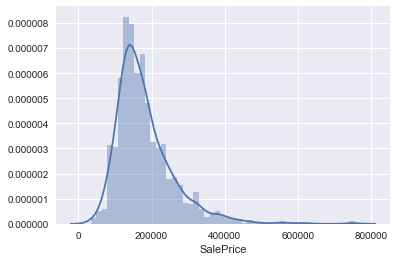

In [160]:
sns.distplot(numerical_houses['SalePrice']);
numerical_houses['SalePrice'].describe()

Analizzo mappa di calore:

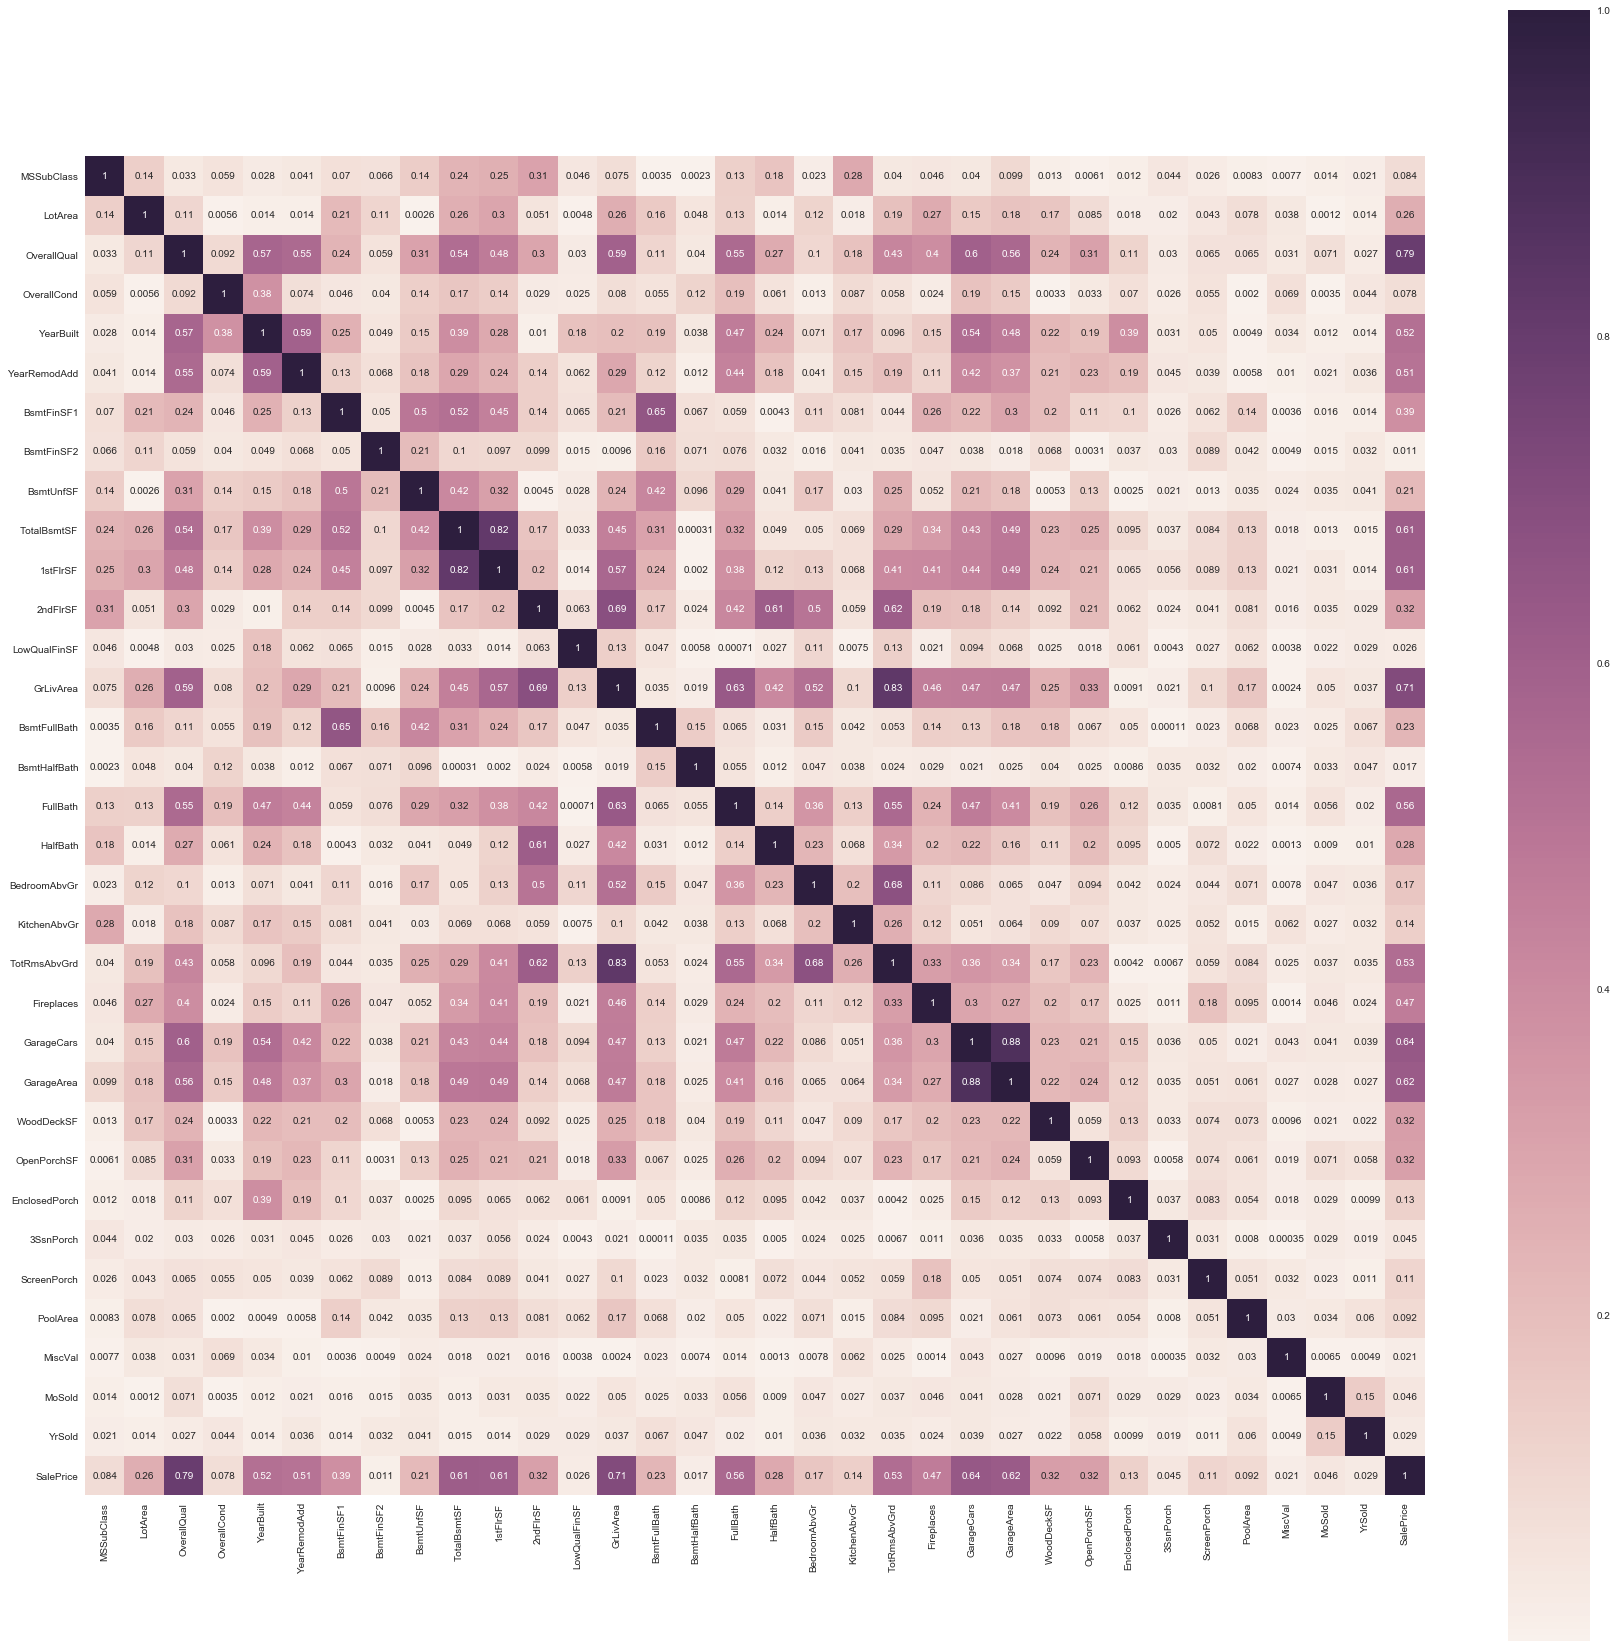

In [161]:
corrmat = numerical_houses.corr().abs()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, annot=True, square=True);

Seleziono le features con correlazione >0.75:

In [162]:
soglia = 0.75
s = corrmat.unstack()
best_features = s[s<1].sort_values()[s>soglia]
l1, l2 = zip(*best_features.index.tolist())
name_best_features = list(set(l1).intersection(l2))
print("Le features con correlazione > "+str(soglia)+" sono: ")
best_features


Le features con correlazione > 0.75 sono: 


OverallQual   SalePrice       0.790982
SalePrice     OverallQual     0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64

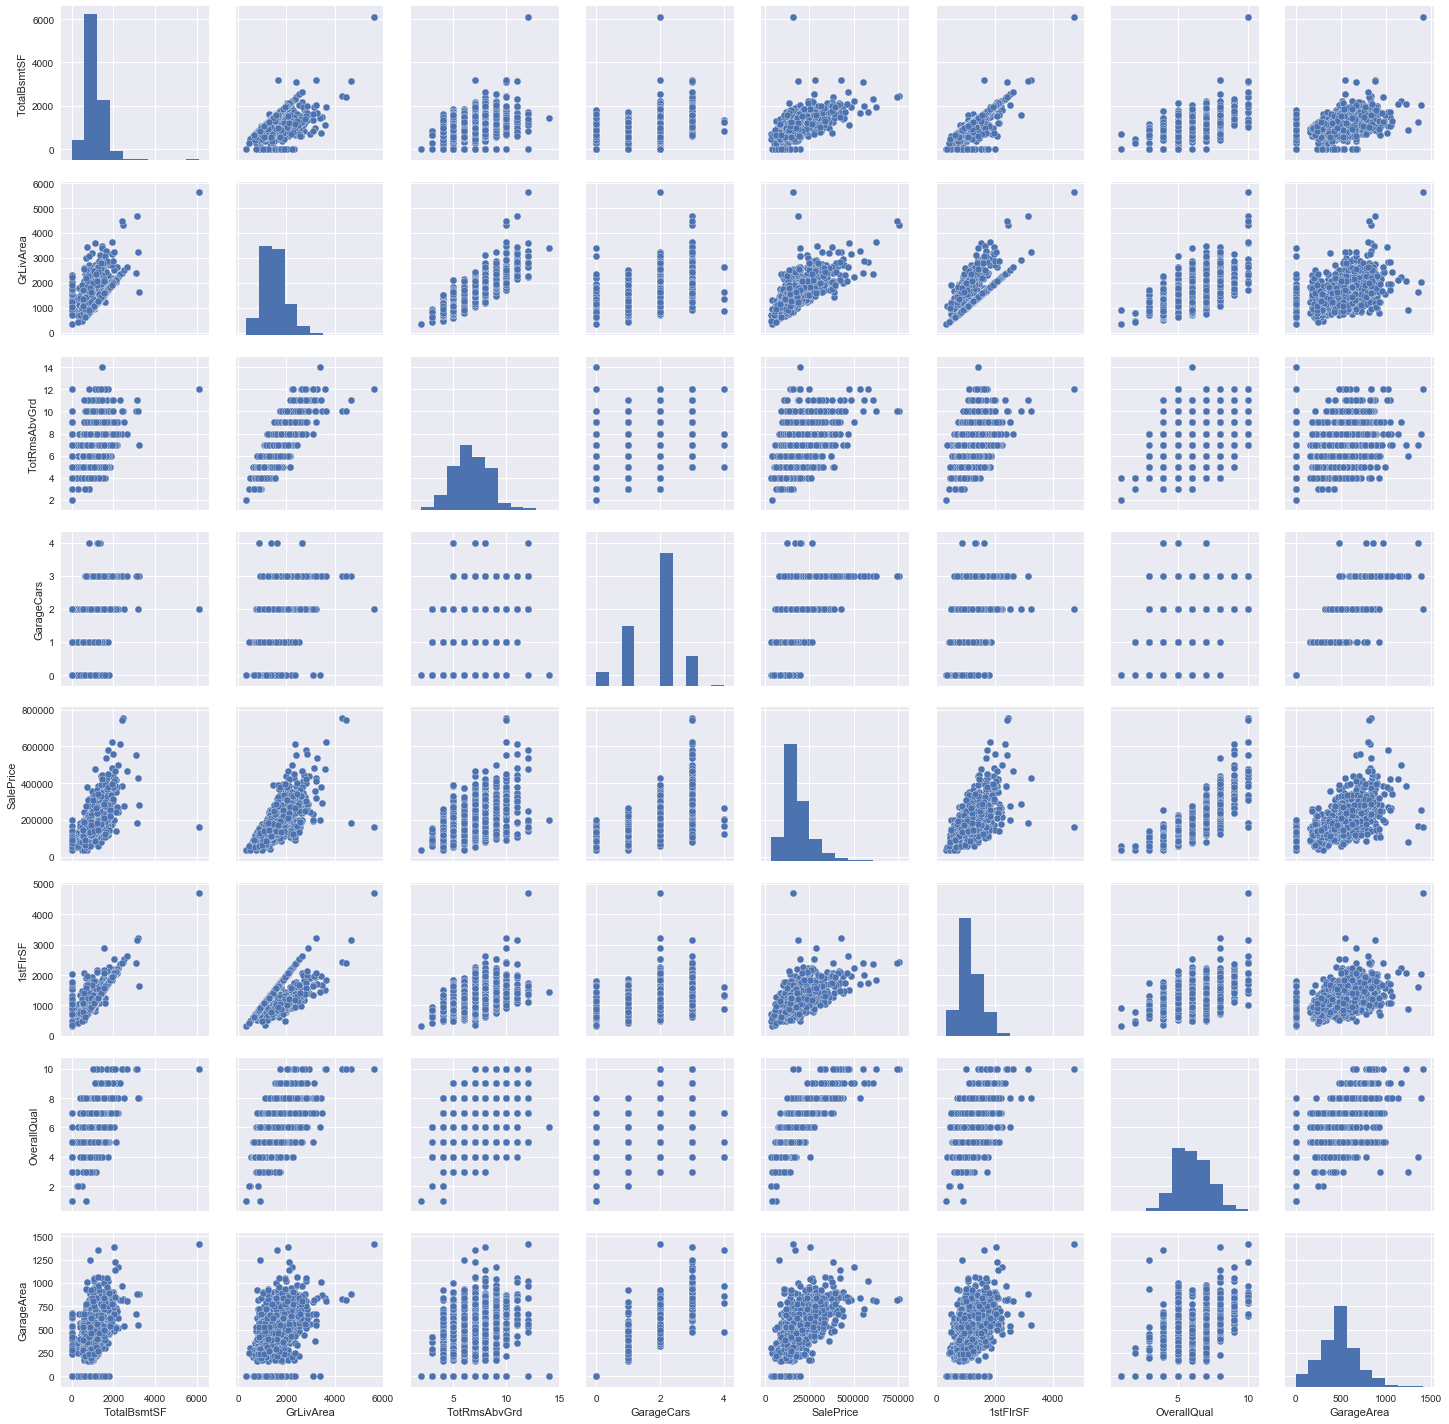

In [163]:
#scatterplot
sns.set()
sns.pairplot(houses[name_best_features], size = 2.5)
plt.show();

In [164]:
#let's select the features with highest correlation wrt the attribute 'SalePrice'
saleCorr = corrmat['SalePrice']
highest_corr_feats = saleCorr.nlargest(10)
highest_corr_feats

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

As we can notice from the results, we picked the data with higher correlation wrt to the target attribute.
There are a couple of things that we may consider:
- as we expected OverallQual and GrLivArea are the dominant values for the price, but pretty surprisingly we don't find Neighborhood even though it's reasonable to think the the price of a house should also depends on that  
- GarageCars and GarageArea have a similar correlation that's probably because they are the same thing i.e. the numbers of cars it's strictly dependent on how big a garage is, so we may consider to drop one of those features cause there are both telling us the same thing


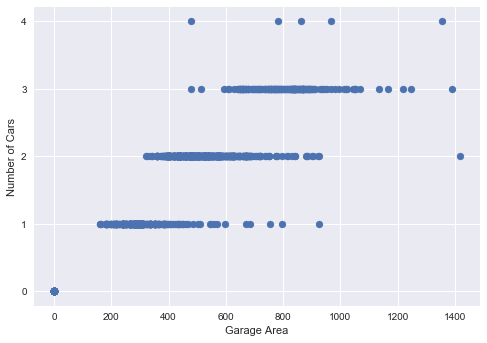

In [165]:
#let's make sure of the relation between GarageCars and GarageArea with a simple scatterplot
x_axis = houses['GarageArea']
y_axis = houses['GarageCars']
plt.scatter(x_axis,y_axis)
plt.xlabel('Garage Area')
plt.ylabel('Number of Cars')
plt.yticks(np.arange(0,5))
plt.show()

Not as much as we expected but there is still a tendence about the relation we said.

### Regressione lineare

In [166]:
# Split the data into training/testing sets
#houses_X_train = houses_X[:-20]
#houses_X_test = houses_X[-20:]

# Split the targets into training/testing sets
#houses_y_train = houses_y[:-20]
#houses_y_test = houses_y[-20:]

#let's stick all together in a function in order to be able to use it all over the notebook

def linRegr(model, iterations, df, test_size):
    tot_score = 0.
    tot_rmse = 0.
    for i in range(iterations):
        train, test = train_test_split(df, test_size=test_size)
    
        X_train = train.drop(['SalePrice'], axis=1)
        y_train = train['SalePrice']
        X_test = test.drop([ 'SalePrice'], axis=1)
        y_test = test['SalePrice']    
    
        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Coefficients: this is the m term in the formula f(x) = mx + q
        #print('Coefficients: \n', regr.coef_, regr.intercept_)
        # Mean squared error
        rmse = mean_squared_error(y_test, model.predict(X_test))**0.5
        print("Root mean squared error: %.2f"% rmse)
        # Explained variance score: 1 is perfect prediction
        score = model.score(X_test, y_test)
        print('Variance score: %.2f' % score)
        tot_rmse += rmse
        tot_score += score
    
    print('\nAverage score: %.2f' % float(tot_score/iterations))
    print('Average rmse: %.2f' % float(tot_rmse/iterations))    

In [167]:
#using the whole dataset

# Create linear regression object
model = linear_model.LinearRegression()
linRegr(model, 10, df=numerical_houses, test_size=0.3)

Root mean squared error: 44783.49
Variance score: 0.70
Root mean squared error: 33243.59
Variance score: 0.83
Root mean squared error: 28144.79
Variance score: 0.86
Root mean squared error: 47636.01
Variance score: 0.58
Root mean squared error: 42869.44
Variance score: 0.73
Root mean squared error: 42786.27
Variance score: 0.69
Root mean squared error: 35076.26
Variance score: 0.79
Root mean squared error: 30368.17
Variance score: 0.84
Root mean squared error: 31970.30
Variance score: 0.82
Root mean squared error: 32948.75
Variance score: 0.79

Average score: 0.76
Average rmse: 36982.71


We may now try to train the same model but only using the selected features wrt to the correlation with 'SalePrice'

In [168]:
#As we mentioned above we drop GarageArea 
cols = highest_corr_feats.drop('GarageArea',axis=0).index
highest_corr_df = houses[cols]
#highest_corr_df.head()
model=linear_model.LinearRegression() 
linRegr(model=model,iterations=10, df=highest_corr_df, test_size=0.3) #this would get rid of 'SalePrice' column as well

Root mean squared error: 36111.09
Variance score: 0.74
Root mean squared error: 48348.41
Variance score: 0.64
Root mean squared error: 34856.72
Variance score: 0.82
Root mean squared error: 34016.43
Variance score: 0.80
Root mean squared error: 37741.48
Variance score: 0.80
Root mean squared error: 42334.96
Variance score: 0.77
Root mean squared error: 39269.49
Variance score: 0.74
Root mean squared error: 33529.06
Variance score: 0.80
Root mean squared error: 48682.05
Variance score: 0.68
Root mean squared error: 46199.81
Variance score: 0.54

Average score: 0.73
Average rmse: 40108.95


We have improved a little bit but not so much!!

### Alberi di decisione

In [169]:
from sklearn import tree
tree_model=tree.DecisionTreeRegressor()
iterations = 10
linRegr(model=tree_model, df=numerical_houses, iterations=iterations, test_size=0.3)


Root mean squared error: 41465.74
Variance score: 0.72
Root mean squared error: 42904.13
Variance score: 0.76
Root mean squared error: 42614.09
Variance score: 0.72
Root mean squared error: 39950.52
Variance score: 0.76
Root mean squared error: 42524.06
Variance score: 0.73
Root mean squared error: 46536.29
Variance score: 0.70
Root mean squared error: 42128.82
Variance score: 0.70
Root mean squared error: 40389.43
Variance score: 0.72
Root mean squared error: 45603.93
Variance score: 0.63
Root mean squared error: 34265.24
Variance score: 0.75

Average score: 0.72
Average rmse: 41838.23


In [180]:
#let's try only the high_corr_features as before
linRegr(model=tree_model,iterations=10, df=highest_corr_df, test_size=0.3) #this would get rid of 'SalePrice' column as well


Root mean squared error: 41574.03
Variance score: 0.75
Root mean squared error: 47742.42
Variance score: 0.67
Root mean squared error: 43963.14
Variance score: 0.68
Root mean squared error: 50016.91
Variance score: 0.60
Root mean squared error: 46372.30
Variance score: 0.68
Root mean squared error: 54531.12
Variance score: 0.51
Root mean squared error: 55254.61
Variance score: 0.62
Root mean squared error: 43914.32
Variance score: 0.75
Root mean squared error: 39298.57
Variance score: 0.74
Root mean squared error: 47905.47
Variance score: 0.61

Average score: 0.66
Average rmse: 47057.29


## Feature reduction
### Principal component analysis

In [181]:
from sklearn import decomposition
#numerical_houses = numerical_houses.drop(['SalePrice'], axis=1)

In [182]:
pca = decomposition.PCA(n_components=25)
pca.fit(numerical_houses)
reducted_houses = pd.DataFrame(data=pca.transform(numerical_houses))
reducted_houses['SalePrice'] = houses['SalePrice']
reducted_houses.shape

(1460, 26)

In [186]:
linRegr(model=tree_model,iterations=100, df=reducted_houses, test_size=0.3)

Root mean squared error: 9960.59
Variance score: 0.99
Root mean squared error: 9964.84
Variance score: 0.99
Root mean squared error: 3567.40
Variance score: 1.00
Root mean squared error: 7370.14
Variance score: 0.99
Root mean squared error: 7225.53
Variance score: 0.99
Root mean squared error: 14969.27
Variance score: 0.97
Root mean squared error: 4280.35
Variance score: 1.00
Root mean squared error: 3952.90
Variance score: 1.00
Root mean squared error: 14240.24
Variance score: 0.98
Root mean squared error: 10671.27
Variance score: 0.98
Root mean squared error: 6023.44
Variance score: 0.99
Root mean squared error: 2877.85
Variance score: 1.00
Root mean squared error: 1425.43
Variance score: 1.00
Root mean squared error: 2138.75
Variance score: 1.00
Root mean squared error: 11964.56
Variance score: 0.98
Root mean squared error: 3653.86
Variance score: 1.00
Root mean squared error: 6001.49
Variance score: 1.00
Root mean squared error: 10654.70
Variance score: 0.98
Root mean squared error